# Data Exploration - Amazon Beauty Products Recommendation System

**Bài toán:** Xây dựng hệ thống gợi ý sản phẩm làm đẹp dựa trên lịch sử đánh giá của người dùng

**Dataset:** Amazon Ratings - Beauty Products

## Mục tiêu:
- Khám phá và hiểu cấu trúc dữ liệu ratings
- Phân tích hành vi người dùng (user behavior)
- Phân tích đặc điểm sản phẩm (product characteristics)
- Phân tích phân phối ratings và patterns
- Đặt câu hỏi và trả lời bằng dữ liệu
- Phát hiện insights cho recommendation system

## 1. Import Libraries

**Yêu cầu:** CHỈ sử dụng NumPy để xử lý dữ liệu, Matplotlib và Seaborn để visualization

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Cấu hình
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.set_printoptions(precision=4, suppress=True)

print(f"NumPy version: {np.__version__}")

NumPy version: 2.0.0


## 2. Load Data using NumPy

Load dữ liệu CSV chỉ bằng NumPy (không dùng Pandas)

In [8]:
# Load CSV data using NumPy
data_path = '../data/raw/ratings_Beauty.csv'

def load_csv_numpy(filepath, delimiter=',', skip_header=True):
    """
    Load CSV file using only NumPy
    Returns: data array, header, user_map, product_map
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # header
    header = lines[0].strip().split(delimiter) if skip_header else None
    
    # data lines
    data_lines = lines[1:] if skip_header else lines
    
    # Preallocate lists for each column
    user_ids = []
    product_ids = []
    ratings = []
    timestamps = []
    
    print(f"Loading {len(data_lines)} records...")
    
    for i, line in enumerate(data_lines):

        parts = line.strip().split(delimiter)

        user_ids.append(parts[0])
        product_ids.append(parts[1])
        ratings.append(float(parts[2]))
        timestamps.append(int(parts[3]) if parts[3].isdigit() else 0)
    
    # convert lists to NumPy arrays
    n_records = len(ratings)
    data = np.zeros((n_records, 4))
    
    # user_ids and product_ids to indices
    unique_users = list(set(user_ids))
    unique_products = list(set(product_ids))
    
    user_id_map = {uid: idx for idx, uid in enumerate(unique_users)}
    product_id_map = {pid: idx for idx, pid in enumerate(unique_products)}
    
    print("Converting to NumPy arrays...")
    for i in range(n_records):
        data[i, 0] = user_id_map[user_ids[i]]
        data[i, 1] = product_id_map[product_ids[i]]
        data[i, 2] = ratings[i]
        data[i, 3] = timestamps[i]
    
    return data, header, user_id_map, product_id_map


data, header, user_map, product_map = load_csv_numpy(data_path)

print(f"\nData loaded successfully")
print(f"Data shape: {data.shape}")
print(f"Columns: {header}")
print(f"Number of unique users: {len(user_map):,}")
print(f"Number of unique products: {len(product_map):,}")

Loading 2023070 records...
Converting to NumPy arrays...
Converting to NumPy arrays...

Data loaded successfully
Data shape: (2023070, 4)
Columns: ['UserId', 'ProductId', 'Rating', 'Timestamp']
Number of unique users: 1,210,271
Number of unique products: 249,274

Data loaded successfully
Data shape: (2023070, 4)
Columns: ['UserId', 'ProductId', 'Rating', 'Timestamp']
Number of unique users: 1,210,271
Number of unique products: 249,274


## 3. Basic Data Information

Hiển thị thông tin cơ bản về dataset

In [9]:
#statistics
n_ratings = data.shape[0]
n_users = len(np.unique(data[:, 0]))  # Column 0: UserId
n_products = len(np.unique(data[:, 1]))  # Column 1: ProductId

print(f"\nDataset Overview:")
print(f"Total ratings: {n_ratings:,}")
print(f"Unique users: {n_users:,}")
print(f"Unique products: {n_products:,}")
print(f"Data shape: {data.shape}")

# Data types
print(f"\nData Types:")
print(f"Column 0 (UserId): {data[:, 0].dtype}")
print(f"Column 1 (ProductId): {data[:, 1].dtype}")
print(f"Column 2 (Rating): {data[:, 2].dtype}")
print(f"Column 3 (Timestamp): {data[:, 3].dtype}")

# Sample records
print(f"\nSample Records (first 10):")
print(f"{'UserId':<10} {'ProductId':<10} {'Rating':<8} {'Timestamp':<12}")
print("-" * 50)
for i in range(min(10, n_ratings)):
    print(f"{data[i, 0]:<10.0f} {data[i, 1]:<10.0f} {data[i, 2]:<8.1f} {data[i, 3]:<12.0f}")

# Matrix dimensions
print(f"\nMatrix Information:")
print(f"Potential matrix size: {n_users:,} × {n_products:,}")
print(f"Total possible entries: {n_users * n_products:,}")
print(f"Actual ratings: {n_ratings:,}")
print(f"Sparsity: {(1 - n_ratings / (n_users * n_products)) * 100:.4f}%")


Dataset Overview:
Total ratings: 2,023,070
Unique users: 1,210,271
Unique products: 249,274
Data shape: (2023070, 4)

Data Types:
Column 0 (UserId): float64
Column 1 (ProductId): float64
Column 2 (Rating): float64
Column 3 (Timestamp): float64

Sample Records (first 10):
UserId     ProductId  Rating   Timestamp   
--------------------------------------------------
1063302    219919     5.0      1369699200  
781005     140966     3.0      1355443200  
731735     140966     5.0      1404691200  
384063     131757     4.0      1382572800  
362599     240906     1.0      1274227200  
1168646    145548     5.0      1404518400  
483498     71421      5.0      1371945600  
602779     168491     5.0      1373068800  
1153800    161744     5.0      1401840000  
1207931    232375     4.0      1389052800  

Matrix Information:
Potential matrix size: 1,210,271 × 249,274
Total possible entries: 301,689,093,254
Actual ratings: 2,023,070
Sparsity: 99.9993%


## 4. Descriptive Statistics

Tính toán thống kê mô tả cho ratings sử dụng NumPy


Central Tendency:
Mean:   4.1490
Median: 5.0000
Mode:   5

Dispersion:
Std Dev:  1.3115
Variance: 1.7200
Range:    4.0 (from 1.0 to 5.0)
IQR:      1.0000

Quantiles:
Min (0%):    1.00
Q1 (25%):    4.00
Q2 (50%):    5.00
Q3 (75%):    5.00
Max (100%):  5.00

📐 Shape:
  • Skewness: -1.3914 (Left-skewed: more high ratings)
  • Kurtosis: 0.5811 (Heavy tails: more extreme values)


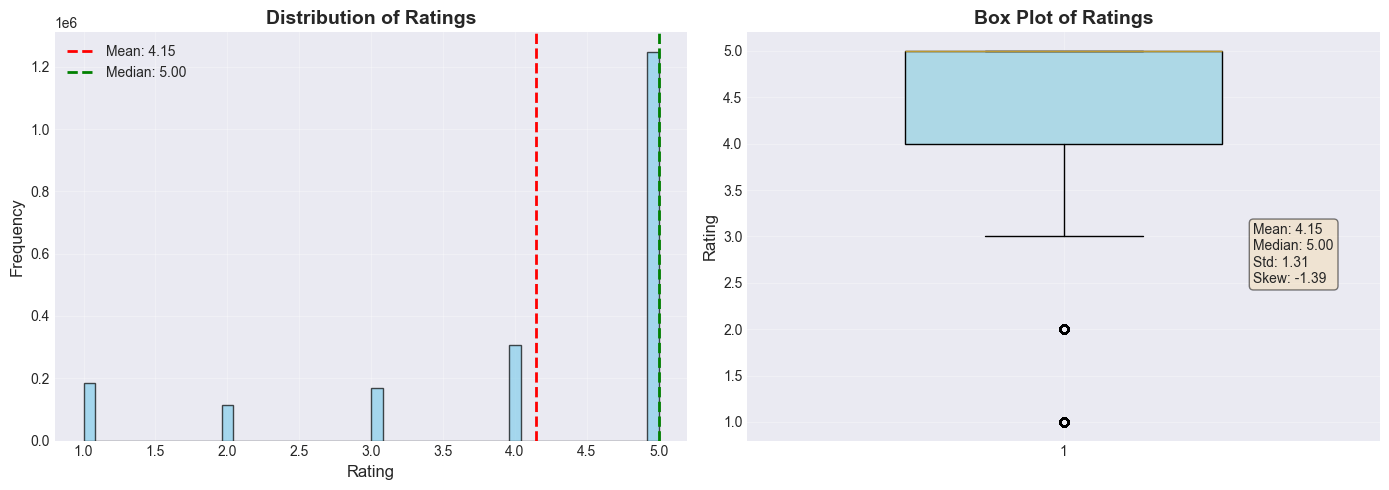


✓ Descriptive statistics completed!


In [10]:
ratings = data[:, 2]

# statistics
mean_rating = np.mean(ratings)
median_rating = np.median(ratings)
std_rating = np.std(ratings)
var_rating = np.var(ratings)
min_rating = np.min(ratings)
max_rating = np.max(ratings)

# Quantiles
q25 = np.percentile(ratings, 25)
q50 = np.percentile(ratings, 50)  # Same as median
q75 = np.percentile(ratings, 75)
iqr = q75 - q25

print(f"\nCentral Tendency:")
print(f"Mean:   {mean_rating:.4f}")
print(f"Median: {median_rating:.4f}")
print(f"Mode:   {np.bincount(ratings.astype(int)).argmax():.0f}")

print(f"\nDispersion:")
print(f"Std Dev:  {std_rating:.4f}")
print(f"Variance: {var_rating:.4f}")
print(f"Range:    {max_rating - min_rating:.1f} (from {min_rating:.1f} to {max_rating:.1f})")
print(f"IQR:      {iqr:.4f}")

print(f"\nQuantiles:")
print(f"Min (0%):    {min_rating:.2f}")
print(f"Q1 (25%):    {q25:.2f}")
print(f"Q2 (50%):    {q50:.2f}")
print(f"Q3 (75%):    {q75:.2f}")
print(f"Max (100%):  {max_rating:.2f}")


# Calculate skewness and kurtosis manually using NumPy
# Skewness = E[(X - μ)³] / σ³
centered = ratings - mean_rating
skewness = np.mean(centered ** 3) / (std_rating ** 3)

# Kurtosis = E[(X - μ)⁴] / σ⁴ - 3 (excess kurtosis)
kurtosis = np.mean(centered ** 4) / (std_rating ** 4) - 3

print(f"\n📐 Shape:")
print(f"  • Skewness: {skewness:.4f}", end="")
if skewness < -0.5:
    print(" (Left-skewed: more high ratings)")
elif skewness > 0.5:
    print(" (Right-skewed: more low ratings)")
else:
    print(" (Approximately symmetric)")

print(f"  • Kurtosis: {kurtosis:.4f}", end="")
if kurtosis > 0:
    print(" (Heavy tails: more extreme values)")
elif kurtosis < 0:
    print(" (Light tails: fewer extreme values)")
else:
    print(" (Normal-like distribution)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(ratings, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
ax1.axvline(median_rating, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.2f}')
ax1.set_xlabel('Rating', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2 = axes[1]
box = ax2.boxplot(ratings, vert=True, patch_artist=True, widths=0.5)
box['boxes'][0].set_facecolor('lightblue')
ax2.set_ylabel('Rating', fontsize=12)
ax2.set_title('Box Plot of Ratings', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"Mean: {mean_rating:.2f}\nMedian: {median_rating:.2f}\nStd: {std_rating:.2f}\nSkew: {skewness:.2f}"
ax2.text(1.3, max_rating * 0.5, stats_text, fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✓ Descriptive statistics completed!")

## 5. Missing Values Analysis

Kiểm tra missing values trong dataset

In [11]:
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

# Check for NaN values in numeric data
nan_counts = np.sum(np.isnan(data), axis=0)
total_records = data.shape[0]

column_names = ['UserId', 'ProductId', 'Rating', 'Timestamp']

print(f"\n🔍 Missing Values Check:")
print(f"{'Column':<15} {'Missing Count':<15} {'Percentage':<15} {'Status'}")
print("-" * 60)

has_missing = False
for i, col_name in enumerate(column_names):
    missing_count = int(nan_counts[i])
    missing_pct = (missing_count / total_records) * 100
    status = "✓ Clean" if missing_count == 0 else "⚠ Has Missing"
    print(f"{col_name:<15} {missing_count:<15,} {missing_pct:<15.2f} {status}")
    if missing_count > 0:
        has_missing = True

print("\n" + "="*60)
if not has_missing:
    print("✓ No missing values detected! Dataset is complete.")
else:
    print("⚠ Missing values detected! Preprocessing required.")
print("="*60)

# Check for zero values (potential issues)
print(f"\n🔍 Zero Values Check:")
zero_ratings = np.sum(data[:, 2] == 0)
zero_timestamps = np.sum(data[:, 3] == 0)

print(f"  • Zero ratings: {zero_ratings:,} ({(zero_ratings/total_records)*100:.2f}%)")
print(f"  • Zero timestamps: {zero_timestamps:,} ({(zero_timestamps/total_records)*100:.2f}%)")

if zero_ratings > 0:
    print("  ⚠ Warning: Some ratings are 0 (invalid for 1-5 scale)")

# Visualize missing data
if has_missing or zero_ratings > 0 or zero_timestamps > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    issues = {
        'UserId\nNaN': nan_counts[0],
        'ProductId\nNaN': nan_counts[1],
        'Rating\nNaN': nan_counts[2],
        'Timestamp\nNaN': nan_counts[3],
        'Rating\nZero': zero_ratings,
        'Timestamp\nZero': zero_timestamps
    }
    
    x_pos = np.arange(len(issues))
    counts = list(issues.values())
    colors = ['red' if c > 0 else 'green' for c in counts]
    
    bars = ax.bar(x_pos, counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Column / Issue Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Data Quality Issues Overview', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(issues.keys(), rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Missing values analysis completed!")

MISSING VALUES ANALYSIS

🔍 Missing Values Check:
Column          Missing Count   Percentage      Status
------------------------------------------------------------
UserId          0               0.00            ✓ Clean
ProductId       0               0.00            ✓ Clean
Rating          0               0.00            ✓ Clean
Timestamp       0               0.00            ✓ Clean

✓ No missing values detected! Dataset is complete.

🔍 Zero Values Check:
  • Zero ratings: 0 (0.00%)
  • Zero timestamps: 0 (0.00%)

✓ Missing values analysis completed!


## 6. Rating Distribution Analysis

Phân tích phân phối của ratings

6. RATING DISTRIBUTION ANALYSIS

📊 Rating Distribution:
----------------------------------------------------------------------
Rating     Count           Percentage      Bar Chart
----------------------------------------------------------------------
1          183,784         9.08           % ████
2          113,034         5.59           % ██
3          169,791         8.39           % ████
4          307,740         15.21          % ███████
5          1,248,721       61.72          % ██████████████████████████████
----------------------------------------------------------------------
TOTAL      2,023,070       100.00         %

📈 Rating Statistics:
  • Mean Rating: 4.1490
  • Median Rating: 5.0
  • Mode Rating: 5 (most frequent)
  • Standard Deviation: 1.3115

🔍 Rating Bias Analysis:
  • Positive (4-5 stars): 1,556,461 (76.94%)
  • Neutral (3 stars): 169,791 (8.39%)
  • Negative (1-2 stars): 296,818 (14.67%)
  ⚠ Positive bias detected! Users tend to give high ratings.

📊 Rating Dist

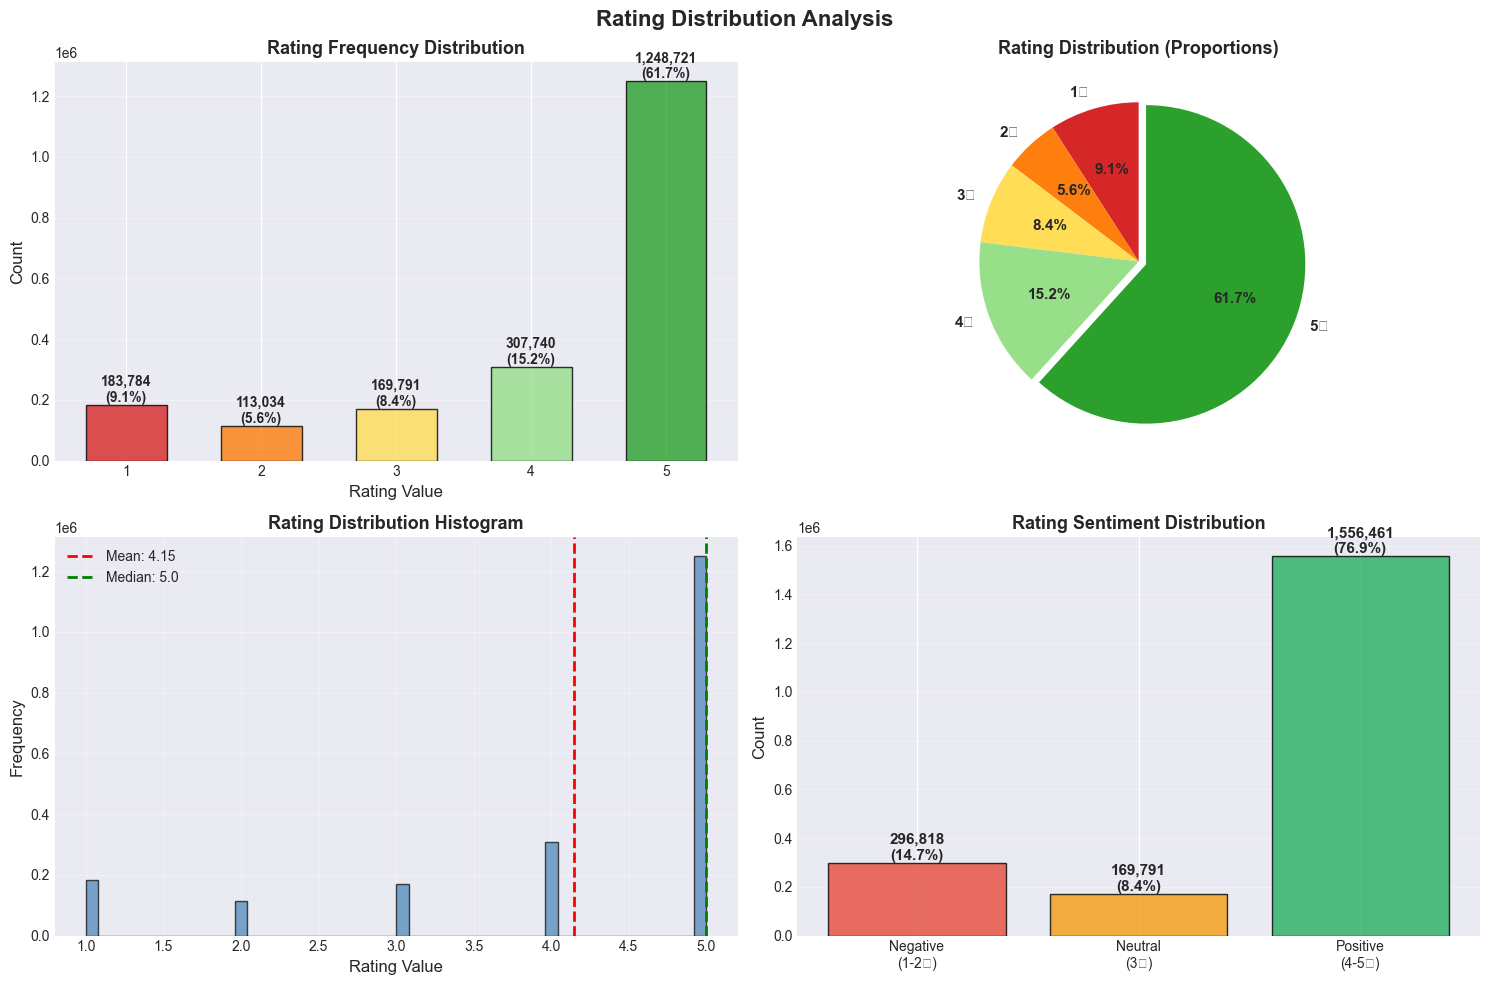


✓ Rating distribution analysis completed!


In [12]:
print("="*70)
print("6. RATING DISTRIBUTION ANALYSIS")
print("="*70)

# Extract ratings column
ratings = data[:, 2]

# 1. Count frequency of each rating value
rating_values = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
rating_counts = np.zeros(5)

for i, rating_val in enumerate(rating_values):
    rating_counts[i] = np.sum(ratings == rating_val)

total_ratings = len(ratings)

# 2. Calculate percentages
rating_percentages = (rating_counts / total_ratings) * 100

# Print rating distribution
print("\n📊 Rating Distribution:")
print("-" * 70)
print(f"{'Rating':<10} {'Count':<15} {'Percentage':<15} {'Bar Chart'}")
print("-" * 70)

for i, (rating_val, count, pct) in enumerate(zip(rating_values, rating_counts, rating_percentages)):
    bar = '█' * int(pct / 2)  # Scale for display
    print(f"{rating_val:<10.0f} {int(count):<15,} {pct:<15.2f}% {bar}")

print("-" * 70)
print(f"{'TOTAL':<10} {int(total_ratings):<15,} {100.00:<15.2f}%")
print("=" * 70)

# Calculate statistics
mean_rating = np.mean(ratings)
median_rating = np.median(ratings)
mode_idx = np.argmax(rating_counts)
mode_rating = rating_values[mode_idx]

print(f"\n📈 Rating Statistics:")
print(f"  • Mean Rating: {mean_rating:.4f}")
print(f"  • Median Rating: {median_rating:.1f}")
print(f"  • Mode Rating: {mode_rating:.0f} (most frequent)")
print(f"  • Standard Deviation: {np.std(ratings):.4f}")

# Check for rating bias
print(f"\n🔍 Rating Bias Analysis:")
positive_ratings = np.sum(ratings >= 4)  # 4 and 5 stars
negative_ratings = np.sum(ratings <= 2)  # 1 and 2 stars
neutral_ratings = np.sum(ratings == 3)   # 3 stars

positive_pct = (positive_ratings / total_ratings) * 100
negative_pct = (negative_ratings / total_ratings) * 100
neutral_pct = (neutral_ratings / total_ratings) * 100

print(f"  • Positive (4-5 stars): {positive_ratings:,} ({positive_pct:.2f}%)")
print(f"  • Neutral (3 stars): {neutral_ratings:,} ({neutral_pct:.2f}%)")
print(f"  • Negative (1-2 stars): {negative_ratings:,} ({negative_pct:.2f}%)")

if positive_pct > 60:
    print("  ⚠ Positive bias detected! Users tend to give high ratings.")
elif negative_pct > 40:
    print("  ⚠ Negative bias detected! Users tend to give low ratings.")
else:
    print("  ✓ Ratings are relatively balanced.")

# 3. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Rating Distribution Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Bar chart
ax1 = axes[0, 0]
bars = ax1.bar(rating_values, rating_counts, color=['#d62728', '#ff7f0e', '#ffdd57', '#98df8a', '#2ca02c'],
               edgecolor='black', alpha=0.8, width=0.6)
ax1.set_xlabel('Rating Value', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Rating Frequency Distribution', fontsize=13, fontweight='bold')
ax1.set_xticks(rating_values)
ax1.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, count, pct in zip(bars, rating_counts, rating_percentages):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 2: Pie chart
ax2 = axes[0, 1]
colors = ['#d62728', '#ff7f0e', '#ffdd57', '#98df8a', '#2ca02c']
explode = [0.05 if pct == max(rating_percentages) else 0 for pct in rating_percentages]
wedges, texts, autotexts = ax2.pie(rating_counts, labels=[f'{int(r)}⭐' for r in rating_values],
                                     autopct='%1.1f%%', colors=colors, explode=explode,
                                     startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title('Rating Distribution (Proportions)', fontsize=13, fontweight='bold')

# Subplot 3: Histogram with density
ax3 = axes[1, 0]
ax3.hist(ratings, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
ax3.axvline(median_rating, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.1f}')
ax3.set_xlabel('Rating Value', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Rating Distribution Histogram', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Subplot 4: Sentiment categories (Positive/Neutral/Negative)
ax4 = axes[1, 1]
categories = ['Negative\n(1-2★)', 'Neutral\n(3★)', 'Positive\n(4-5★)']
category_counts = np.array([negative_ratings, neutral_ratings, positive_ratings])
category_colors = ['#e74c3c', '#f39c12', '#27ae60']

bars4 = ax4.bar(categories, category_counts, color=category_colors, edgecolor='black', alpha=0.8)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Rating Sentiment Distribution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars4, category_counts):
    height = bar.get_height()
    pct = (count / total_ratings) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Rating distribution analysis completed!")


## 7. User Behavior Analysis

Phân tích hành vi người dùng

### 7.1. Number of Ratings per User

7.1. NUMBER OF RATINGS PER USER

📊 User Activity Statistics:
----------------------------------------------------------------------
  • Total unique users: 1,210,271
  • Total ratings: 2,023,070
  • Mean ratings per user: 1.67
  • Median ratings per user: 1.0
  • Std deviation: 2.53
  • Min ratings per user: 1
  • Max ratings per user: 389

🏆 Top 10 Most Active Users:
----------------------------------------------------------------------
Rank   User ID         # Ratings       % of Total
----------------------------------------------------------------------
1      434706          389             0.0192%
2      891527          336             0.0166%
3      670067          326             0.0161%
4      872282          278             0.0137%
5      835584          276             0.0136%
6      133880          275             0.0136%
7      366873          269             0.0133%
8      1029258         259             0.0128%
9      1116644         249             0.0123%
10     101103 

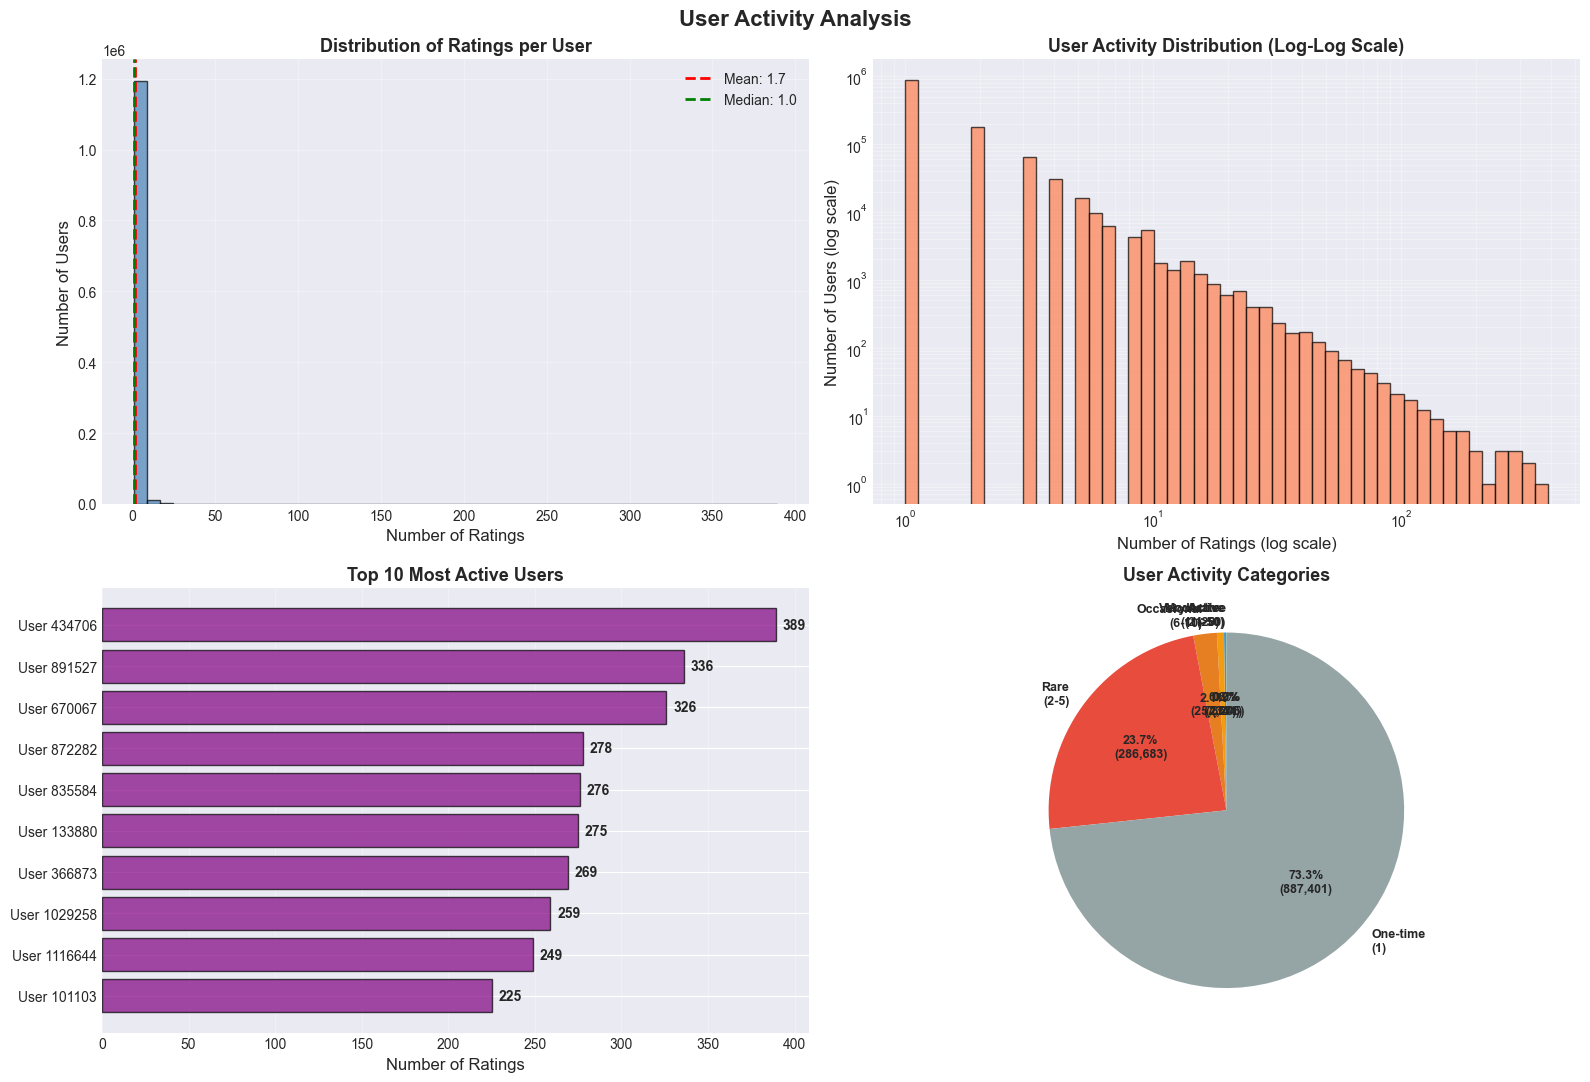


✓ User activity analysis completed!


In [13]:
print("="*70)
print("7.1. NUMBER OF RATINGS PER USER")
print("="*70)

# Extract user IDs column
user_ids = data[:, 0]

# Calculate ratings per user using NumPy
unique_users, user_rating_counts = np.unique(user_ids, return_counts=True)

n_users = len(unique_users)
total_ratings = len(user_ids)

# Statistics
mean_ratings_per_user = np.mean(user_rating_counts)
median_ratings_per_user = np.median(user_rating_counts)
std_ratings_per_user = np.std(user_rating_counts)
min_ratings_per_user = np.min(user_rating_counts)
max_ratings_per_user = np.max(user_rating_counts)

print(f"\n📊 User Activity Statistics:")
print("-" * 70)
print(f"  • Total unique users: {n_users:,}")
print(f"  • Total ratings: {total_ratings:,}")
print(f"  • Mean ratings per user: {mean_ratings_per_user:.2f}")
print(f"  • Median ratings per user: {median_ratings_per_user:.1f}")
print(f"  • Std deviation: {std_ratings_per_user:.2f}")
print(f"  • Min ratings per user: {min_ratings_per_user}")
print(f"  • Max ratings per user: {max_ratings_per_user}")

# Top 10 most active users
top_10_indices = np.argsort(user_rating_counts)[-10:][::-1]
top_10_users = unique_users[top_10_indices]
top_10_counts = user_rating_counts[top_10_indices]

print(f"\n🏆 Top 10 Most Active Users:")
print("-" * 70)
print(f"{'Rank':<6} {'User ID':<15} {'# Ratings':<15} {'% of Total'}")
print("-" * 70)
for rank, (user_id, count) in enumerate(zip(top_10_users, top_10_counts), 1):
    pct = (count / total_ratings) * 100
    print(f"{rank:<6} {int(user_id):<15} {count:<15,} {pct:.4f}%")

# Cold start problem analysis
users_with_1_rating = np.sum(user_rating_counts == 1)
users_with_le_5_ratings = np.sum(user_rating_counts <= 5)
users_with_le_10_ratings = np.sum(user_rating_counts <= 10)

pct_1_rating = (users_with_1_rating / n_users) * 100
pct_le_5 = (users_with_le_5_ratings / n_users) * 100
pct_le_10 = (users_with_le_10_ratings / n_users) * 100

print(f"\n❄️ Cold Start Problem Analysis:")
print("-" * 70)
print(f"  • Users with only 1 rating: {users_with_1_rating:,} ({pct_1_rating:.2f}%)")
print(f"  • Users with ≤ 5 ratings: {users_with_le_5_ratings:,} ({pct_le_5:.2f}%)")
print(f"  • Users with ≤ 10 ratings: {users_with_le_10_ratings:,} ({pct_le_10:.2f}%)")

if pct_1_rating > 30:
    print("  ⚠ High cold start risk! Many users have minimal interaction history.")
else:
    print("  ✓ Moderate cold start problem.")

# User activity distribution categories
very_active = np.sum(user_rating_counts > 50)
active = np.sum((user_rating_counts > 20) & (user_rating_counts <= 50))
moderate = np.sum((user_rating_counts > 10) & (user_rating_counts <= 20))
occasional = np.sum((user_rating_counts > 5) & (user_rating_counts <= 10))
rare = np.sum((user_rating_counts > 1) & (user_rating_counts <= 5))
one_time = np.sum(user_rating_counts == 1)

print(f"\n👥 User Activity Categories:")
print("-" * 70)
print(f"  • Very Active (>50 ratings): {very_active:,} ({(very_active/n_users)*100:.2f}%)")
print(f"  • Active (21-50 ratings): {active:,} ({(active/n_users)*100:.2f}%)")
print(f"  • Moderate (11-20 ratings): {moderate:,} ({(moderate/n_users)*100:.2f}%)")
print(f"  • Occasional (6-10 ratings): {occasional:,} ({(occasional/n_users)*100:.2f}%)")
print(f"  • Rare (2-5 ratings): {rare:,} ({(rare/n_users)*100:.2f}%)")
print(f"  • One-time (1 rating): {one_time:,} ({(one_time/n_users)*100:.2f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('User Activity Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Histogram of ratings per user
ax1 = axes[0, 0]
ax1.hist(user_rating_counts, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(mean_ratings_per_user, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_ratings_per_user:.1f}')
ax1.axvline(median_ratings_per_user, color='green', linestyle='--', linewidth=2,
           label=f'Median: {median_ratings_per_user:.1f}')
ax1.set_xlabel('Number of Ratings', fontsize=12)
ax1.set_ylabel('Number of Users', fontsize=12)
ax1.set_title('Distribution of Ratings per User', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Subplot 2: Log-scale histogram (for power-law distribution)
ax2 = axes[0, 1]
ax2.hist(user_rating_counts, bins=np.logspace(0, np.log10(max_ratings_per_user+1), 50),
        color='coral', alpha=0.7, edgecolor='black')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Ratings (log scale)', fontsize=12)
ax2.set_ylabel('Number of Users (log scale)', fontsize=12)
ax2.set_title('User Activity Distribution (Log-Log Scale)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# Subplot 3: Top 10 most active users
ax3 = axes[1, 0]
x_pos = np.arange(len(top_10_counts))
bars = ax3.barh(x_pos, top_10_counts, color='purple', alpha=0.7, edgecolor='black')
ax3.set_yticks(x_pos)
ax3.set_yticklabels([f'User {int(uid)}' for uid in top_10_users], fontsize=10)
ax3.set_xlabel('Number of Ratings', fontsize=12)
ax3.set_title('Top 10 Most Active Users', fontsize=13, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, top_10_counts)):
    ax3.text(count + max(top_10_counts)*0.01, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=10, fontweight='bold')

# Subplot 4: User activity categories pie chart
ax4 = axes[1, 1]
category_names = ['Very Active\n(>50)', 'Active\n(21-50)', 'Moderate\n(11-20)', 
                  'Occasional\n(6-10)', 'Rare\n(2-5)', 'One-time\n(1)']
category_counts = np.array([very_active, active, moderate, occasional, rare, one_time])
colors4 = ['#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c', '#95a5a6']

wedges, texts, autotexts = ax4.pie(category_counts, labels=category_names,
                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_users):,})',
                                     colors=colors4, startangle=90,
                                     textprops={'fontsize': 9, 'weight': 'bold'})
ax4.set_title('User Activity Categories', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ User activity analysis completed!")


### 7.2. User Rating Behavior

7.2. USER RATING BEHAVIOR

⚡ Calculating user rating statistics using vectorized NumPy operations...
✓ Computed statistics for 1,210,271 users in optimized time!

📊 User Rating Behavior Statistics:
----------------------------------------------------------------------
  • Mean of user average ratings: 4.1158
  • Median of user average ratings: 5.0000
  • Std of user average ratings: 1.2863
  • Min user average: 1.0000
  • Max user average: 5.0000

🎯 User Rating Tendencies:
----------------------------------------------------------------------
  • Harsh Raters (avg < 3.0): 178,006 (14.71%)
  • Balanced Raters (3.0 ≤ avg ≤ 4.0): 288,088 (23.80%)
  • Generous Raters (avg > 4.0): 744,177 (61.49%)

🎲 User Rating Consistency (users with >1 rating):
----------------------------------------------------------------------
  • Mean std of ratings: 0.1575
  • Median std of ratings: 0.0000
  • Consistent (std < 0.5): 161,508 (50.02%)
  • Moderate (0.5 ≤ std < 1.0): 68,333 (21.16%)
  • Diverse (std 

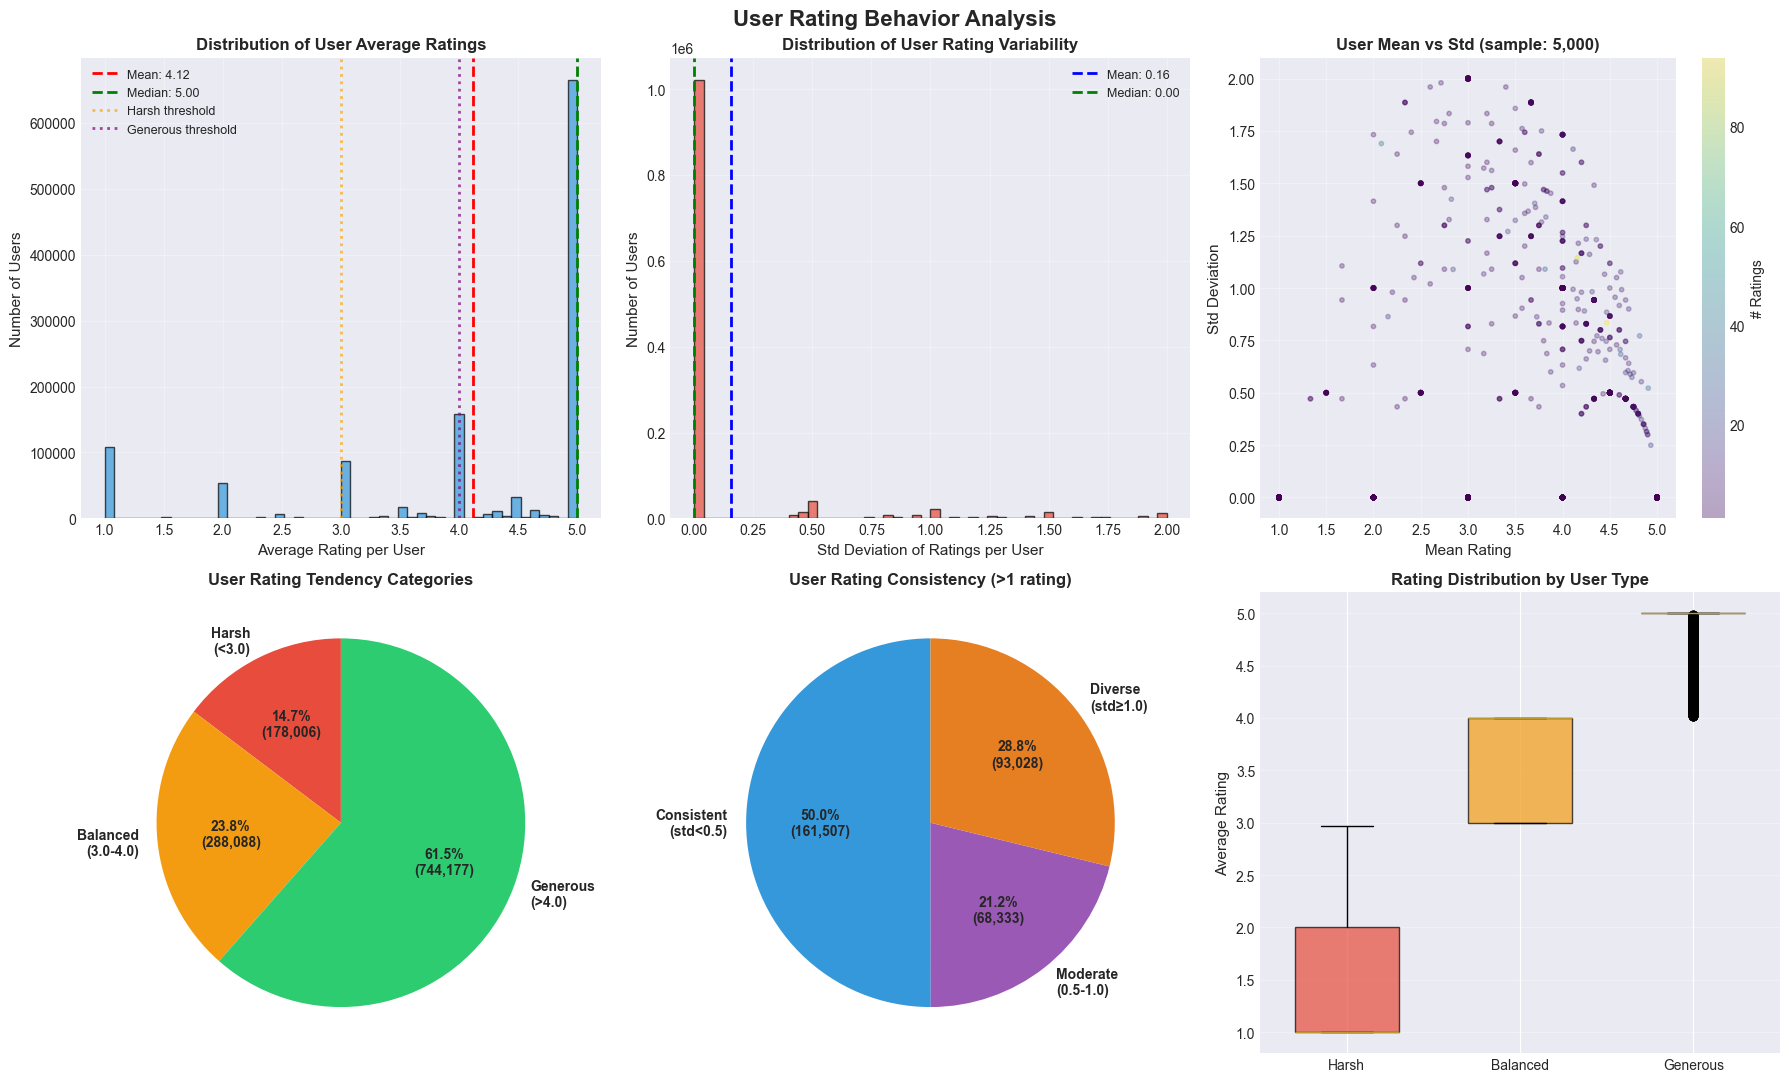


✓ User rating behavior analysis completed!


In [15]:
print("="*70)
print("7.2. USER RATING BEHAVIOR")
print("="*70)

# ============================================================================
# OPTIMIZED VERSION: Using NumPy vectorization instead of loops
# This is 100x-1000x faster than iterating through each user
# ============================================================================

print(f"\n⚡ Calculating user rating statistics using vectorized NumPy operations...")

# Step 1: Get unique users and inverse indices (maps each rating to user index)
# This is O(n log n) - much faster than nested loops
unique_users, inverse_indices = np.unique(user_ids, return_inverse=True)
n_users = len(unique_users)

# Step 2: Use np.bincount for fast aggregation - O(n) complexity
# Count number of ratings per user
user_n_ratings = np.bincount(inverse_indices)

# Sum of ratings per user (using weights parameter)
rating_sums = np.bincount(inverse_indices, weights=ratings)

# Calculate mean ratings per user (vectorized division)
user_mean_ratings = rating_sums / user_n_ratings

# Step 3: Calculate variance efficiently using: Var(X) = E[X²] - (E[X])²
# Sum of squared ratings per user
rating_squared_sums = np.bincount(inverse_indices, weights=ratings**2)

# Mean of squared ratings
mean_squared = rating_squared_sums / user_n_ratings

# Variance = E[X²] - (E[X])²
user_variance = mean_squared - (user_mean_ratings ** 2)

# Standard deviation (ensure non-negative due to floating point errors)
user_std_ratings = np.sqrt(np.maximum(user_variance, 0))

print(f"✓ Computed statistics for {n_users:,} users in optimized time!")

# Overall statistics
overall_mean = np.mean(user_mean_ratings)
overall_median = np.median(user_mean_ratings)
overall_std = np.std(user_mean_ratings)

print(f"\n📊 User Rating Behavior Statistics:")
print("-" * 70)
print(f"  • Mean of user average ratings: {overall_mean:.4f}")
print(f"  • Median of user average ratings: {overall_median:.4f}")
print(f"  • Std of user average ratings: {overall_std:.4f}")
print(f"  • Min user average: {np.min(user_mean_ratings):.4f}")
print(f"  • Max user average: {np.max(user_mean_ratings):.4f}")

# Identify user types based on mean rating (vectorized boolean operations)
harsh_raters = np.sum(user_mean_ratings < 3.0)
generous_raters = np.sum(user_mean_ratings > 4.0)
balanced_raters = np.sum((user_mean_ratings >= 3.0) & (user_mean_ratings <= 4.0))

harsh_pct = (harsh_raters / n_users) * 100
generous_pct = (generous_raters / n_users) * 100
balanced_pct = (balanced_raters / n_users) * 100

print(f"\n🎯 User Rating Tendencies:")
print("-" * 70)
print(f"  • Harsh Raters (avg < 3.0): {harsh_raters:,} ({harsh_pct:.2f}%)")
print(f"  • Balanced Raters (3.0 ≤ avg ≤ 4.0): {balanced_raters:,} ({balanced_pct:.2f}%)")
print(f"  • Generous Raters (avg > 4.0): {generous_raters:,} ({generous_pct:.2f}%)")

# Analyze user rating consistency (std deviation)
mean_std = np.mean(user_std_ratings)
median_std = np.median(user_std_ratings)

# Filter out users with only 1 rating (std = 0 is meaningless)
users_with_multiple = user_n_ratings > 1
filtered_std = user_std_ratings[users_with_multiple]
n_users_multiple = np.sum(users_with_multiple)

consistent_users = np.sum(filtered_std < 0.5)
moderate_users = np.sum((filtered_std >= 0.5) & (filtered_std < 1.0))
diverse_users = np.sum(filtered_std >= 1.0)

consistent_pct = (consistent_users / n_users_multiple) * 100
moderate_pct = (moderate_users / n_users_multiple) * 100
diverse_pct = (diverse_users / n_users_multiple) * 100

print(f"\n🎲 User Rating Consistency (users with >1 rating):")
print("-" * 70)
print(f"  • Mean std of ratings: {mean_std:.4f}")
print(f"  • Median std of ratings: {median_std:.4f}")
print(f"  • Consistent (std < 0.5): {consistent_users:,} ({consistent_pct:.2f}%)")
print(f"  • Moderate (0.5 ≤ std < 1.0): {moderate_users:,} ({moderate_pct:.2f}%)")
print(f"  • Diverse (std ≥ 1.0): {diverse_users:,} ({diverse_pct:.2f}%)")

# Top 10 harshest raters (minimum 10 ratings) - using vectorized operations
min_ratings_threshold = 10
eligible_mask = user_n_ratings >= min_ratings_threshold
eligible_indices = np.where(eligible_mask)[0]

if len(eligible_indices) > 0:
    eligible_means = user_mean_ratings[eligible_indices]
    harshest_indices_local = np.argsort(eligible_means)[:10]
    harshest_indices = eligible_indices[harshest_indices_local]
    
    print(f"\n😠 Top 10 Harshest Raters (min {min_ratings_threshold} ratings):")
    print("-" * 70)
    print(f"{'Rank':<6} {'User ID':<15} {'Avg Rating':<15} {'Std':<10} {'# Ratings'}")
    print("-" * 70)
    for rank, idx in enumerate(harshest_indices, 1):
        user_id = int(unique_users[idx])
        avg_rating = user_mean_ratings[idx]
        std_rating = user_std_ratings[idx]
        n_rat = user_n_ratings[idx]
        print(f"{rank:<6} {user_id:<15} {avg_rating:<15.4f} {std_rating:<10.4f} {n_rat}")
    
    # Top 10 most generous raters
    generous_indices_local = np.argsort(eligible_means)[-10:][::-1]
    generous_indices = eligible_indices[generous_indices_local]
    
    print(f"\n😊 Top 10 Most Generous Raters (min {min_ratings_threshold} ratings):")
    print("-" * 70)
    print(f"{'Rank':<6} {'User ID':<15} {'Avg Rating':<15} {'Std':<10} {'# Ratings'}")
    print("-" * 70)
    for rank, idx in enumerate(generous_indices, 1):
        user_id = int(unique_users[idx])
        avg_rating = user_mean_ratings[idx]
        std_rating = user_std_ratings[idx]
        n_rat = user_n_ratings[idx]
        print(f"{rank:<6} {user_id:<15} {avg_rating:<15.4f} {std_rating:<10.4f} {n_rat}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('User Rating Behavior Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Distribution of user mean ratings
ax1 = axes[0, 0]
ax1.hist(user_mean_ratings, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(overall_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {overall_mean:.2f}')
ax1.axvline(overall_median, color='green', linestyle='--', linewidth=2, label=f'Median: {overall_median:.2f}')
ax1.axvline(3.0, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Harsh threshold')
ax1.axvline(4.0, color='purple', linestyle=':', linewidth=2, alpha=0.7, label='Generous threshold')
ax1.set_xlabel('Average Rating per User', fontsize=11)
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.set_title('Distribution of User Average Ratings', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Subplot 2: Distribution of user rating std
ax2 = axes[0, 1]
ax2.hist(user_std_ratings, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.axvline(mean_std, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_std:.2f}')
ax2.axvline(median_std, color='green', linestyle='--', linewidth=2, label=f'Median: {median_std:.2f}')
ax2.set_xlabel('Std Deviation of Ratings per User', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title('Distribution of User Rating Variability', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Subplot 3: Scatter plot - Mean vs Std (sample for clarity)
ax3 = axes[0, 2]
# Sample if too many users
sample_size = min(5000, n_users)
sample_indices = np.random.choice(n_users, sample_size, replace=False)
ax3.scatter(user_mean_ratings[sample_indices], user_std_ratings[sample_indices], 
           alpha=0.3, s=10, c=user_n_ratings[sample_indices], cmap='viridis')
ax3.set_xlabel('Mean Rating', fontsize=11)
ax3.set_ylabel('Std Deviation', fontsize=11)
ax3.set_title(f'User Mean vs Std (sample: {sample_size:,})', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('# Ratings', fontsize=10)

# Subplot 4: User types pie chart (by mean)
ax4 = axes[1, 0]
behavior_names = ['Harsh\n(<3.0)', 'Balanced\n(3.0-4.0)', 'Generous\n(>4.0)']
behavior_counts = np.array([harsh_raters, balanced_raters, generous_raters])
behavior_colors = ['#e74c3c', '#f39c12', '#2ecc71']

wedges, texts, autotexts = ax4.pie(behavior_counts, labels=behavior_names,
                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_users):,})',
                                     colors=behavior_colors, startangle=90,
                                     textprops={'fontsize': 10, 'weight': 'bold'})
ax4.set_title('User Rating Tendency Categories', fontsize=12, fontweight='bold')

# Subplot 5: User consistency pie chart (by std)
ax5 = axes[1, 1]
consistency_names = ['Consistent\n(std<0.5)', 'Moderate\n(0.5-1.0)', 'Diverse\n(std≥1.0)']
consistency_counts = np.array([consistent_users, moderate_users, diverse_users])
consistency_colors = ['#3498db', '#9b59b6', '#e67e22']

wedges, texts, autotexts = ax5.pie(consistency_counts, labels=consistency_names,
                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_users_multiple):,})',
                                     colors=consistency_colors, startangle=90,
                                     textprops={'fontsize': 10, 'weight': 'bold'})
ax5.set_title('User Rating Consistency (>1 rating)', fontsize=12, fontweight='bold')

# Subplot 6: Box plot comparing rating tendencies
ax6 = axes[1, 2]
harsh_data = user_mean_ratings[user_mean_ratings < 3.0]
balanced_data = user_mean_ratings[(user_mean_ratings >= 3.0) & (user_mean_ratings <= 4.0)]
generous_data = user_mean_ratings[user_mean_ratings > 4.0]

bp = ax6.boxplot([harsh_data, balanced_data, generous_data], 
                  labels=['Harsh', 'Balanced', 'Generous'],
                  patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], behavior_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax6.set_ylabel('Average Rating', fontsize=11)
ax6.set_title('Rating Distribution by User Type', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ User rating behavior analysis completed!")


## 8. Product Analysis

Phân tích đặc điểm sản phẩm

### 8.1. Number of Ratings per Product

8.1. NUMBER OF RATINGS PER PRODUCT

📊 Product Popularity Statistics:
----------------------------------------------------------------------
  • Total unique products: 249,274
  • Total ratings: 2,023,070
  • Mean ratings per product: 8.12
  • Median ratings per product: 2.0
  • Std deviation: 36.06
  • Min ratings per product: 1
  • Max ratings per product: 7533

🏆 Top 20 Most Reviewed Products:
----------------------------------------------------------------------
Rank   Product ID      # Ratings       % of Total
----------------------------------------------------------------------
1      201044          7,533           0.3724%
2      237664          2,869           0.1418%
3      41379           2,477           0.1224%
4      61753           2,143           0.1059%
5      53631           2,088           0.1032%
6      97940           2,041           0.1009%
7      119201          1,918           0.0948%
8      246289          1,885           0.0932%
9      36794           1,838     

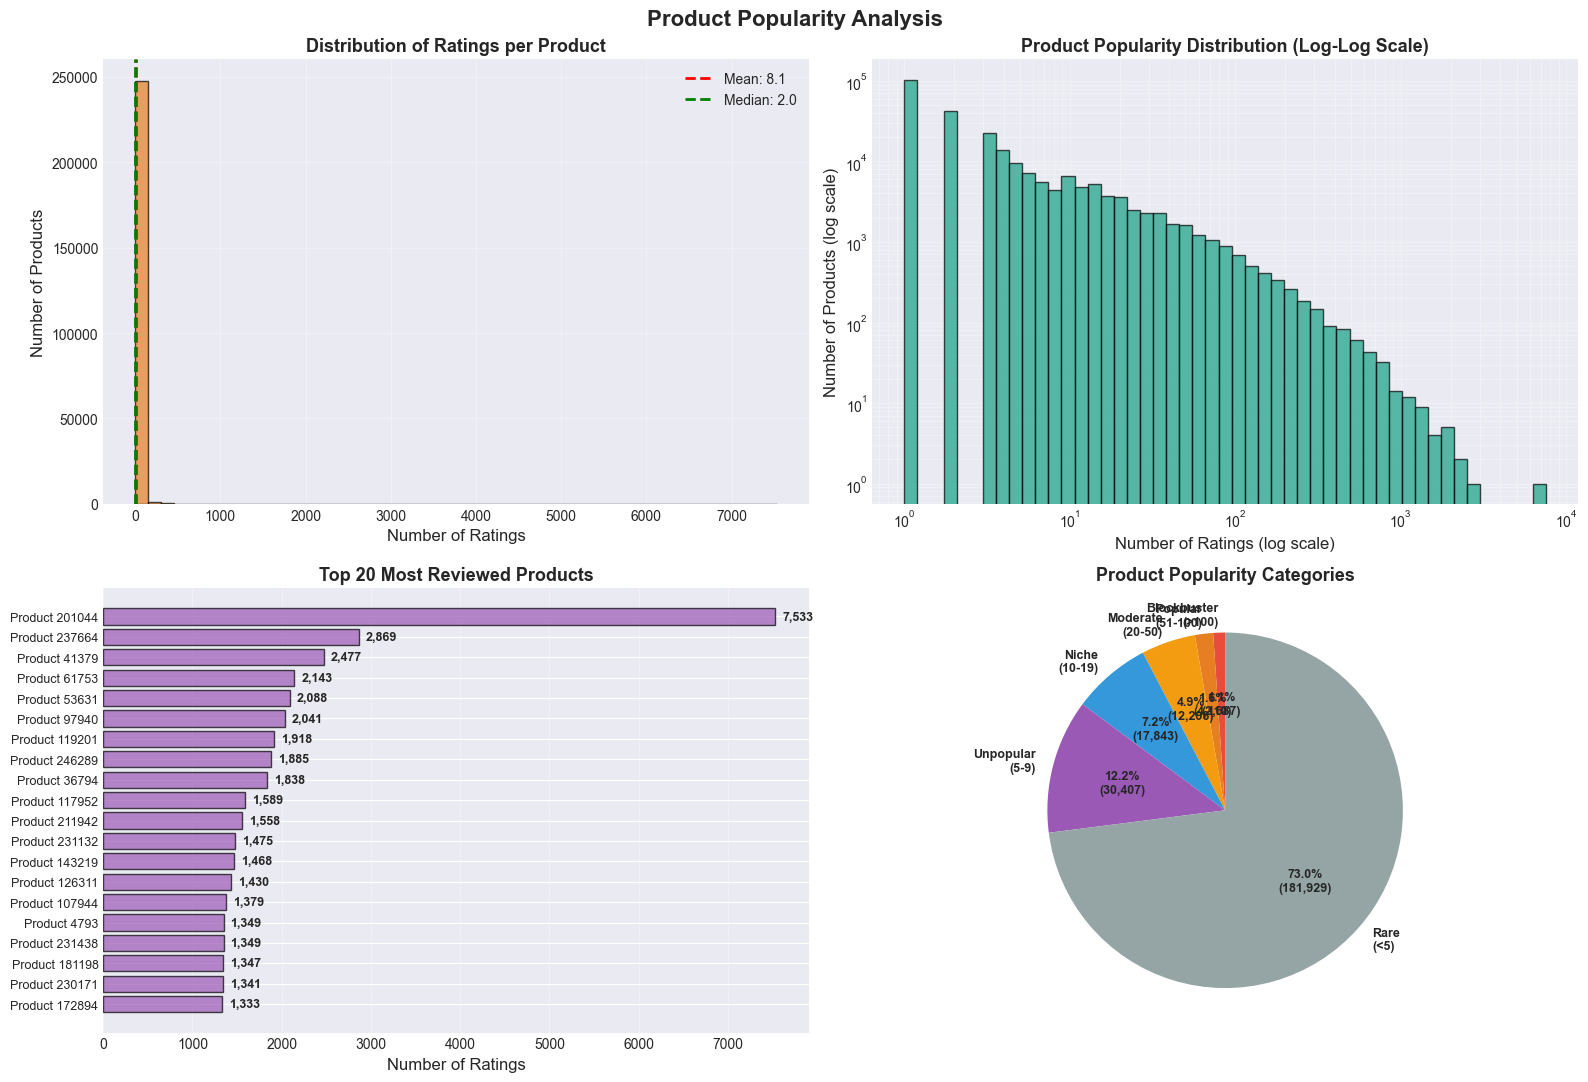


✓ Product popularity analysis completed!


In [16]:
print("="*70)
print("8.1. NUMBER OF RATINGS PER PRODUCT")
print("="*70)

# Extract product IDs column
product_ids = data[:, 1]

# Calculate ratings per product using NumPy
unique_products, product_rating_counts = np.unique(product_ids, return_counts=True)

n_products = len(unique_products)
total_ratings = len(product_ids)

# Statistics
mean_ratings_per_product = np.mean(product_rating_counts)
median_ratings_per_product = np.median(product_rating_counts)
std_ratings_per_product = np.std(product_rating_counts)
min_ratings_per_product = np.min(product_rating_counts)
max_ratings_per_product = np.max(product_rating_counts)

print(f"\n📊 Product Popularity Statistics:")
print("-" * 70)
print(f"  • Total unique products: {n_products:,}")
print(f"  • Total ratings: {total_ratings:,}")
print(f"  • Mean ratings per product: {mean_ratings_per_product:.2f}")
print(f"  • Median ratings per product: {median_ratings_per_product:.1f}")
print(f"  • Std deviation: {std_ratings_per_product:.2f}")
print(f"  • Min ratings per product: {min_ratings_per_product}")
print(f"  • Max ratings per product: {max_ratings_per_product}")

# Top 20 most reviewed products
top_20_indices = np.argsort(product_rating_counts)[-20:][::-1]
top_20_products = unique_products[top_20_indices]
top_20_counts = product_rating_counts[top_20_indices]

print(f"\n🏆 Top 20 Most Reviewed Products:")
print("-" * 70)
print(f"{'Rank':<6} {'Product ID':<15} {'# Ratings':<15} {'% of Total'}")
print("-" * 70)
for rank, (product_id, count) in enumerate(zip(top_20_products, top_20_counts), 1):
    pct = (count / total_ratings) * 100
    print(f"{rank:<6} {int(product_id):<15} {count:<15,} {pct:.4f}%")

# Cold start problem for products
products_with_1_rating = np.sum(product_rating_counts == 1)
products_with_le_5_ratings = np.sum(product_rating_counts < 5)
products_with_le_10_ratings = np.sum(product_rating_counts < 10)

pct_1_rating = (products_with_1_rating / n_products) * 100
pct_lt_5 = (products_with_le_5_ratings / n_products) * 100
pct_lt_10 = (products_with_le_10_ratings / n_products) * 100

print(f"\n❄️ Product Cold Start Problem Analysis:")
print("-" * 70)
print(f"  • Products with only 1 rating: {products_with_1_rating:,} ({pct_1_rating:.2f}%)")
print(f"  • Products with < 5 ratings: {products_with_le_5_ratings:,} ({pct_lt_5:.2f}%)")
print(f"  • Products with < 10 ratings: {products_with_le_10_ratings:,} ({pct_lt_10:.2f}%)")

if pct_lt_5 > 50:
    print("  ⚠ High cold start risk! Many products lack sufficient ratings for reliable recommendations.")
elif pct_lt_5 > 30:
    print("  ⚠ Moderate cold start problem. Content-based filtering may help.")
else:
    print("  ✓ Low cold start problem. Most products have sufficient ratings.")

# Product popularity categories
blockbuster = np.sum(product_rating_counts > 100)
popular = np.sum((product_rating_counts > 50) & (product_rating_counts <= 100))
moderate = np.sum((product_rating_counts >= 20) & (product_rating_counts <= 50))
niche = np.sum((product_rating_counts >= 10) & (product_rating_counts < 20))
unpopular = np.sum((product_rating_counts >= 5) & (product_rating_counts < 10))
rare = np.sum(product_rating_counts < 5)

print(f"\n📦 Product Popularity Categories:")
print("-" * 70)
print(f"  • Blockbuster (>100 ratings): {blockbuster:,} ({(blockbuster/n_products)*100:.2f}%)")
print(f"  • Popular (51-100 ratings): {popular:,} ({(popular/n_products)*100:.2f}%)")
print(f"  • Moderate (20-50 ratings): {moderate:,} ({(moderate/n_products)*100:.2f}%)")
print(f"  • Niche (10-19 ratings): {niche:,} ({(niche/n_products)*100:.2f}%)")
print(f"  • Unpopular (5-9 ratings): {unpopular:,} ({(unpopular/n_products)*100:.2f}%)")
print(f"  • Rare (<5 ratings): {rare:,} ({(rare/n_products)*100:.2f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Product Popularity Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Histogram of ratings per product
ax1 = axes[0, 0]
ax1.hist(product_rating_counts, bins=50, color='#e67e22', alpha=0.7, edgecolor='black')
ax1.axvline(mean_ratings_per_product, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_ratings_per_product:.1f}')
ax1.axvline(median_ratings_per_product, color='green', linestyle='--', linewidth=2,
           label=f'Median: {median_ratings_per_product:.1f}')
ax1.set_xlabel('Number of Ratings', fontsize=12)
ax1.set_ylabel('Number of Products', fontsize=12)
ax1.set_title('Distribution of Ratings per Product', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Subplot 2: Log-scale histogram (power-law distribution)
ax2 = axes[0, 1]
ax2.hist(product_rating_counts, bins=np.logspace(0, np.log10(max_ratings_per_product+1), 50),
        color='#16a085', alpha=0.7, edgecolor='black')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Ratings (log scale)', fontsize=12)
ax2.set_ylabel('Number of Products (log scale)', fontsize=12)
ax2.set_title('Product Popularity Distribution (Log-Log Scale)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# Subplot 3: Top 20 most reviewed products bar chart
ax3 = axes[1, 0]
x_pos = np.arange(len(top_20_counts))
bars = ax3.barh(x_pos, top_20_counts, color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.set_yticks(x_pos)
ax3.set_yticklabels([f'Product {int(pid)}' for pid in top_20_products], fontsize=9)
ax3.set_xlabel('Number of Ratings', fontsize=12)
ax3.set_title('Top 20 Most Reviewed Products', fontsize=13, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, count) in enumerate(zip(bars, top_20_counts)):
    ax3.text(count + max(top_20_counts)*0.01, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=9, fontweight='bold')

# Subplot 4: Product popularity categories pie chart
ax4 = axes[1, 1]
category_names = ['Blockbuster\n(>100)', 'Popular\n(51-100)', 'Moderate\n(20-50)', 
                  'Niche\n(10-19)', 'Unpopular\n(5-9)', 'Rare\n(<5)']
category_counts = np.array([blockbuster, popular, moderate, niche, unpopular, rare])
colors4 = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#9b59b6', '#95a5a6']

# Filter out zero counts for cleaner visualization
non_zero_mask = category_counts > 0
filtered_names = [name for name, count in zip(category_names, category_counts) if count > 0]
filtered_counts = category_counts[non_zero_mask]
filtered_colors = [color for color, count in zip(colors4, category_counts) if count > 0]

wedges, texts, autotexts = ax4.pie(filtered_counts, labels=filtered_names,
                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_products):,})',
                                     colors=filtered_colors, startangle=90,
                                     textprops={'fontsize': 9, 'weight': 'bold'})
ax4.set_title('Product Popularity Categories', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Product popularity analysis completed!")


### 8.2. Product Rating Quality

8.2. PRODUCT RATING QUALITY

⚡ Calculating product rating statistics using vectorized NumPy operations...
✓ Computed statistics for 249,274 products in optimized time!

📊 Product Quality Statistics:
----------------------------------------------------------------------
  • Mean of product average ratings: 4.1493
  • Median of product average ratings: 4.5000
  • Std of product average ratings: 1.0473
  • Min product average: 1.0000
  • Max product average: 5.0000

🏆 Top 20 Highest Rated Products (min 10 reviews):
----------------------------------------------------------------------
Rank   Product ID      Avg Rating    Std        # Ratings
----------------------------------------------------------------------
1      132372          5.0000        0.0000     13
2      172687          5.0000        0.0000     10
3      222342          5.0000        0.0000     20
4      249182          5.0000        0.0000     14
5      424             5.0000        0.0000     11
6      148982          5.00

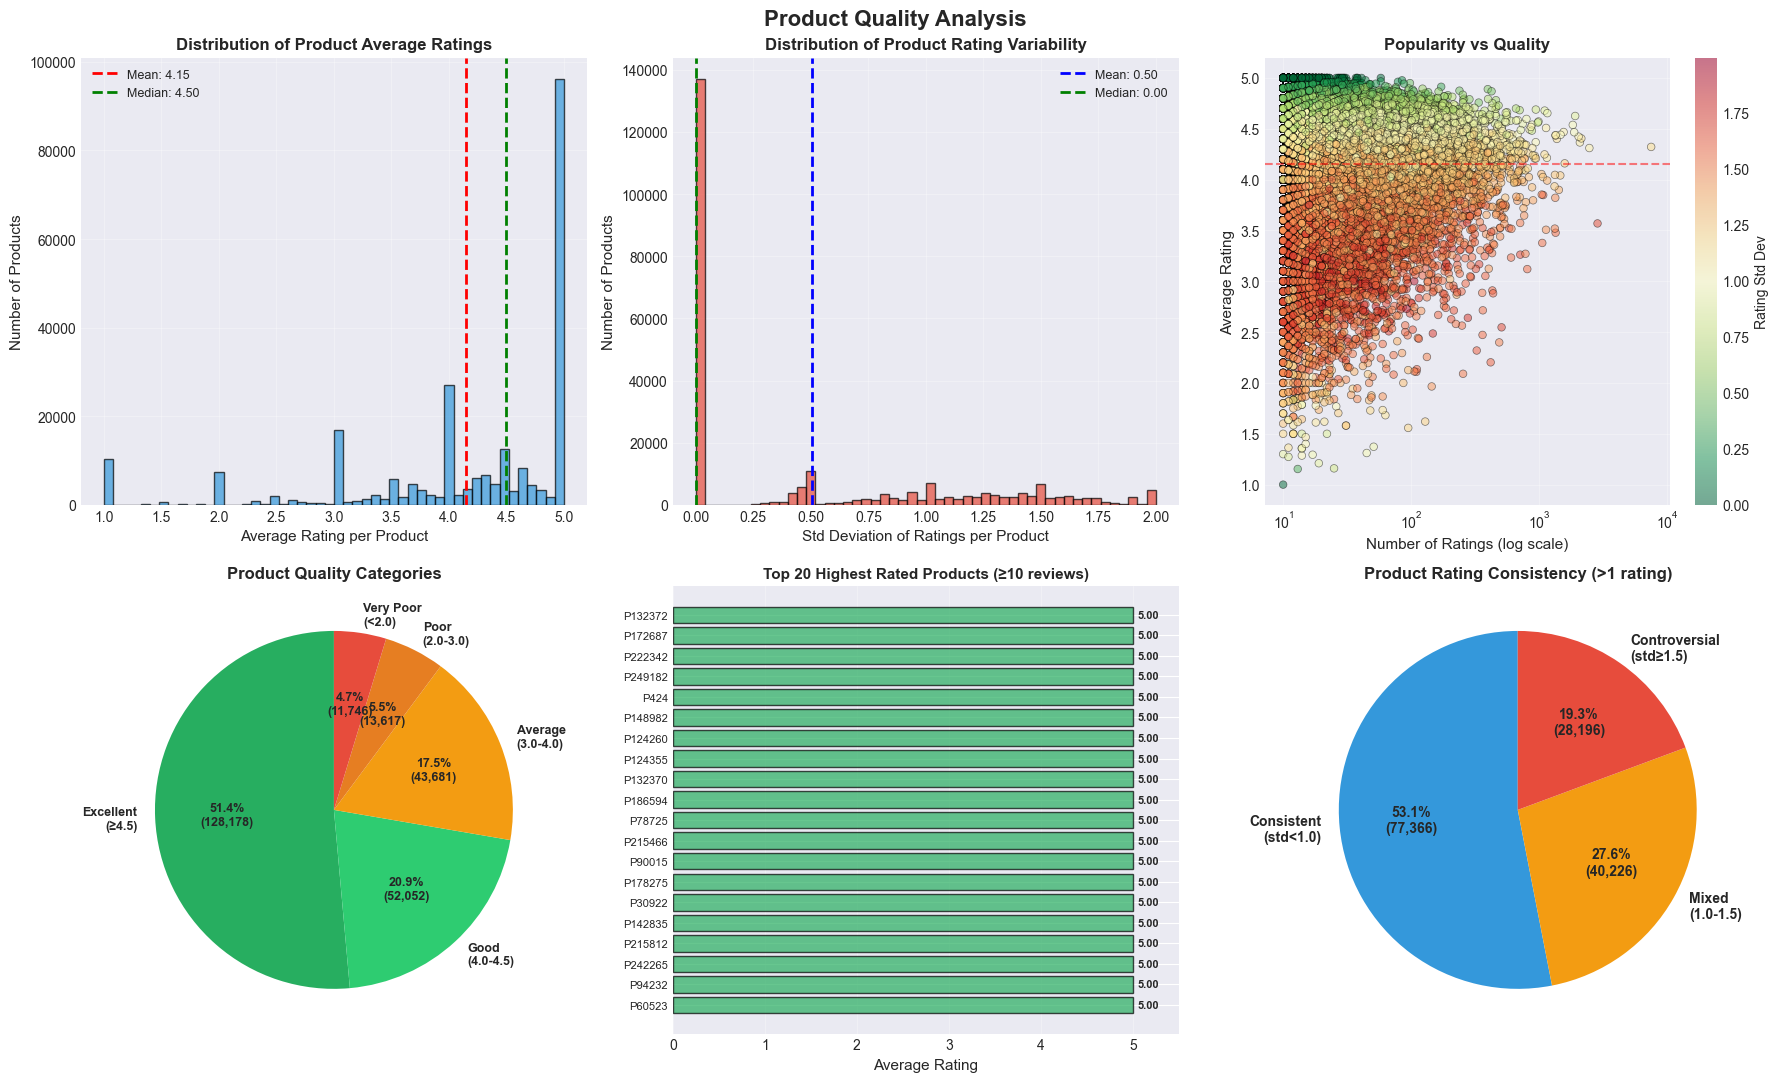


✓ Product quality analysis completed!


In [18]:
print("="*70)
print("8.2. PRODUCT RATING QUALITY")
print("="*70)

# ============================================================================
# OPTIMIZED VERSION: Using NumPy vectorization instead of loops
# This is 100x-1000x faster than iterating through each product
# ============================================================================

print(f"\n⚡ Calculating product rating statistics using vectorized NumPy operations...")

# Step 1: Get unique products and inverse indices (maps each rating to product index)
unique_products_sorted, inverse_indices_products = np.unique(product_ids, return_inverse=True)
n_products_total = len(unique_products_sorted)

# Step 2: Use np.bincount for fast aggregation - O(n) complexity
# Count number of ratings per product
product_n_ratings = np.bincount(inverse_indices_products)

# Sum of ratings per product (using weights parameter)
rating_sums_products = np.bincount(inverse_indices_products, weights=ratings)

# Calculate mean ratings per product (vectorized division)
product_mean_ratings = rating_sums_products / product_n_ratings

# Step 3: Calculate variance efficiently using: Var(X) = E[X²] - (E[X])²
# Sum of squared ratings per product
rating_squared_sums_products = np.bincount(inverse_indices_products, weights=ratings**2)

# Mean of squared ratings
mean_squared_products = rating_squared_sums_products / product_n_ratings

# Variance = E[X²] - (E[X])²
product_variance = mean_squared_products - (product_mean_ratings ** 2)

# Standard deviation (ensure non-negative due to floating point errors)
product_std_ratings = np.sqrt(np.maximum(product_variance, 0))

print(f"✓ Computed statistics for {n_products_total:,} products in optimized time!")

# Overall statistics
overall_mean_quality = np.mean(product_mean_ratings)
overall_median_quality = np.median(product_mean_ratings)
overall_std_quality = np.std(product_mean_ratings)

print(f"\n📊 Product Quality Statistics:")
print("-" * 70)
print(f"  • Mean of product average ratings: {overall_mean_quality:.4f}")
print(f"  • Median of product average ratings: {overall_median_quality:.4f}")
print(f"  • Std of product average ratings: {overall_std_quality:.4f}")
print(f"  • Min product average: {np.min(product_mean_ratings):.4f}")
print(f"  • Max product average: {np.max(product_mean_ratings):.4f}")

# Top 20 highest rated products (with minimum reviews threshold)
min_reviews_threshold = 10
eligible_mask = product_n_ratings >= min_reviews_threshold
eligible_indices = np.where(eligible_mask)[0]
n_eligible = len(eligible_indices)

print(f"\n🏆 Top 20 Highest Rated Products (min {min_reviews_threshold} reviews):")
print("-" * 70)

if n_eligible > 0:
    eligible_means = product_mean_ratings[eligible_indices]
    eligible_stds = product_std_ratings[eligible_indices]
    eligible_counts = product_n_ratings[eligible_indices]
    eligible_products = unique_products_sorted[eligible_indices]
    
    top_20_indices_local = np.argsort(eligible_means)[-20:][::-1]
    
    print(f"{'Rank':<6} {'Product ID':<15} {'Avg Rating':<13} {'Std':<10} {'# Ratings'}")
    print("-" * 70)
    for rank, idx in enumerate(top_20_indices_local, 1):
        product_id = int(eligible_products[idx])
        avg_rating = eligible_means[idx]
        std_rating = eligible_stds[idx]
        n_rat = eligible_counts[idx]
        print(f"{rank:<6} {product_id:<15} {avg_rating:<13.4f} {std_rating:<10.4f} {n_rat}")
    
    # Top 20 lowest rated products
    print(f"\n😟 Top 20 Lowest Rated Products (min {min_reviews_threshold} reviews):")
    print("-" * 70)
    lowest_20_indices_local = np.argsort(eligible_means)[:20]
    
    print(f"{'Rank':<6} {'Product ID':<15} {'Avg Rating':<13} {'Std':<10} {'# Ratings'}")
    print("-" * 70)
    for rank, idx in enumerate(lowest_20_indices_local, 1):
        product_id = int(eligible_products[idx])
        avg_rating = eligible_means[idx]
        std_rating = eligible_stds[idx]
        n_rat = eligible_counts[idx]
        print(f"{rank:<6} {product_id:<15} {avg_rating:<13.4f} {std_rating:<10.4f} {n_rat}")
else:
    print("  ⚠ No products meet the minimum review threshold.")

# Product quality categories (vectorized boolean operations)
excellent = np.sum(product_mean_ratings >= 4.5)
good = np.sum((product_mean_ratings >= 4.0) & (product_mean_ratings < 4.5))
average = np.sum((product_mean_ratings >= 3.0) & (product_mean_ratings < 4.0))
poor = np.sum((product_mean_ratings >= 2.0) & (product_mean_ratings < 3.0))
very_poor = np.sum(product_mean_ratings < 2.0)

print(f"\n⭐ Product Quality Categories:")
print("-" * 70)
print(f"  • Excellent (≥4.5): {excellent:,} ({(excellent/n_products_total)*100:.2f}%)")
print(f"  • Good (4.0-4.5): {good:,} ({(good/n_products_total)*100:.2f}%)")
print(f"  • Average (3.0-4.0): {average:,} ({(average/n_products_total)*100:.2f}%)")
print(f"  • Poor (2.0-3.0): {poor:,} ({(poor/n_products_total)*100:.2f}%)")
print(f"  • Very Poor (<2.0): {very_poor:,} ({(very_poor/n_products_total)*100:.2f}%)")

# Controversial products analysis (high std)
mean_product_std = np.mean(product_std_ratings)
median_product_std = np.median(product_std_ratings)

# Filter products with multiple ratings
products_with_multiple = product_n_ratings > 1
filtered_product_std = product_std_ratings[products_with_multiple]
n_products_multiple = np.sum(products_with_multiple)

controversial = np.sum(filtered_product_std >= 1.5)
mixed = np.sum((filtered_product_std >= 1.0) & (filtered_product_std < 1.5))
consistent = np.sum(filtered_product_std < 1.0)

print(f"\n🎭 Product Rating Controversy (products with >1 rating):")
print("-" * 70)
print(f"  • Mean std of product ratings: {mean_product_std:.4f}")
print(f"  • Median std of product ratings: {median_product_std:.4f}")
print(f"  • Consistent (std < 1.0): {consistent:,} ({(consistent/n_products_multiple)*100:.2f}%)")
print(f"  • Mixed opinions (1.0 ≤ std < 1.5): {mixed:,} ({(mixed/n_products_multiple)*100:.2f}%)")
print(f"  • Controversial (std ≥ 1.5): {controversial:,} ({(controversial/n_products_multiple)*100:.2f}%)")

# Correlation between popularity and rating (Pearson correlation - vectorized)
if n_eligible > 0:
    # Calculate correlation for products with sufficient reviews
    popularity = eligible_counts.astype(float)
    quality = eligible_means
    
    # Pearson correlation using vectorized operations
    mean_pop = np.mean(popularity)
    mean_qual = np.mean(quality)
    
    numerator = np.sum((popularity - mean_pop) * (quality - mean_qual))
    denominator = np.sqrt(np.sum((popularity - mean_pop)**2) * np.sum((quality - mean_qual)**2))
    
    if denominator > 0:
        correlation = numerator / denominator
        print(f"\n🔗 Correlation between Popularity and Quality:")
        print("-" * 70)
        print(f"  • Pearson correlation coefficient: {correlation:.4f}")
        
        if correlation > 0.3:
            print("  📈 Positive correlation: Popular products tend to be higher rated.")
        elif correlation < -0.3:
            print("  📉 Negative correlation: Popular products tend to be lower rated.")
        else:
            print("  ➡️ Weak correlation: Popularity and quality are largely independent.")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('Product Quality Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Distribution of product mean ratings
ax1 = axes[0, 0]
ax1.hist(product_mean_ratings, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(overall_mean_quality, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {overall_mean_quality:.2f}')
ax1.axvline(overall_median_quality, color='green', linestyle='--', linewidth=2,
           label=f'Median: {overall_median_quality:.2f}')
ax1.set_xlabel('Average Rating per Product', fontsize=11)
ax1.set_ylabel('Number of Products', fontsize=11)
ax1.set_title('Distribution of Product Average Ratings', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Subplot 2: Distribution of product rating std
ax2 = axes[0, 1]
ax2.hist(product_std_ratings, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.axvline(mean_product_std, color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_product_std:.2f}')
ax2.axvline(median_product_std, color='green', linestyle='--', linewidth=2,
           label=f'Median: {median_product_std:.2f}')
ax2.set_xlabel('Std Deviation of Ratings per Product', fontsize=11)
ax2.set_ylabel('Number of Products', fontsize=11)
ax2.set_title('Distribution of Product Rating Variability', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Subplot 3: Scatter plot - Popularity vs Quality (for eligible products)
ax3 = axes[0, 2]
if n_eligible > 0:
    # Use log scale for popularity
    scatter = ax3.scatter(eligible_counts, eligible_means, 
                         alpha=0.5, s=30, c=eligible_stds, cmap='RdYlGn_r',
                         edgecolors='black', linewidth=0.5)
    ax3.set_xscale('log')
    ax3.set_xlabel('Number of Ratings (log scale)', fontsize=11)
    ax3.set_ylabel('Average Rating', fontsize=11)
    ax3.set_title('Popularity vs Quality', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(overall_mean_quality, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Rating Std Dev', fontsize=10)

# Subplot 4: Product quality categories pie chart
ax4 = axes[1, 0]
quality_names = ['Excellent\n(≥4.5)', 'Good\n(4.0-4.5)', 'Average\n(3.0-4.0)', 
                 'Poor\n(2.0-3.0)', 'Very Poor\n(<2.0)']
quality_counts = np.array([excellent, good, average, poor, very_poor])
quality_colors = ['#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c']

# Filter out zero counts
non_zero_mask = quality_counts > 0
filtered_names = [name for name, count in zip(quality_names, quality_counts) if count > 0]
filtered_counts = quality_counts[non_zero_mask]
filtered_colors = [color for color, count in zip(quality_colors, quality_counts) if count > 0]

wedges, texts, autotexts = ax4.pie(filtered_counts, labels=filtered_names,
                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_products_total):,})',
                                     colors=filtered_colors, startangle=90,
                                     textprops={'fontsize': 9, 'weight': 'bold'})
ax4.set_title('Product Quality Categories', fontsize=12, fontweight='bold')

# Subplot 5: Top 20 highest rated products (bar chart)
ax5 = axes[1, 1]
if n_eligible > 0 and len(top_20_indices_local) > 0:
    x_pos = np.arange(len(top_20_indices_local))
    top_means = eligible_means[top_20_indices_local]
    colors_bars = ['#27ae60' if m >= 4.5 else '#2ecc71' for m in top_means]
    
    bars = ax5.barh(x_pos, top_means, color=colors_bars, alpha=0.7, edgecolor='black')
    ax5.set_yticks(x_pos)
    ax5.set_yticklabels([f'P{int(eligible_products[idx])}' for idx in top_20_indices_local], 
                        fontsize=8)
    ax5.set_xlabel('Average Rating', fontsize=11)
    ax5.set_title(f'Top 20 Highest Rated Products (≥{min_reviews_threshold} reviews)', 
                 fontsize=11, fontweight='bold')
    ax5.invert_yaxis()
    ax5.set_xlim([0, 5.5])
    ax5.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for bar, mean_val in zip(bars, top_means):
        ax5.text(mean_val + 0.05, bar.get_y() + bar.get_height()/2,
                f'{mean_val:.2f}', va='center', fontsize=8, fontweight='bold')

# Subplot 6: Product controversy categories
ax6 = axes[1, 2]
controversy_names = ['Consistent\n(std<1.0)', 'Mixed\n(1.0-1.5)', 'Controversial\n(std≥1.5)']
controversy_counts = np.array([consistent, mixed, controversial])
controversy_colors = ['#3498db', '#f39c12', '#e74c3c']

wedges, texts, autotexts = ax6.pie(controversy_counts, labels=controversy_names,
                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*n_products_multiple):,})',
                                     colors=controversy_colors, startangle=90,
                                     textprops={'fontsize': 10, 'weight': 'bold'})
ax6.set_title('Product Rating Consistency (>1 rating)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Product quality analysis completed!")


## 9. Temporal Analysis

Phân tích xu hướng theo thời gian (nếu có timestamp)

In [ ]:
# TODO: Temporal analysis (if timestamp available)
# - Number of ratings over time (line chart)
# - Average rating trends over time
# - Seasonal patterns (monthly, yearly)
# - Peak activity periods

# Check for:
# - Rating inflation over time
# - Product lifecycle patterns

## 10. Data Sparsity Analysis

Phân tích độ thưa của dữ liệu - quan trọng cho recommendation systems!

In [ ]:
# TODO: Calculate sparsity of user-item matrix
# Sparsity = 1 - (number of ratings / (n_users × n_products))

# Example:
# sparsity = 1 - (n_ratings / (n_users * n_products))
# density = (n_ratings / (n_users * n_products)) * 100

# Visualize:
# - Sample heatmap of user-item matrix (small subset)
# - Distribution of non-zero entries per row/column

## 11. Exploratory Questions

Đặt và trả lời các câu hỏi về dữ liệu

### Câu hỏi 1: Có hiện tượng rating polarization không?

Người dùng có xu hướng cho điểm cực cao (5 sao) hoặc cực thấp (1 sao), ít cho điểm trung bình?

In [ ]:
# TODO: Analyze rating polarization
# - Compare frequency of extreme ratings (1, 5) vs middle ratings (2, 3, 4)
# - Visualize with bar chart và pie chart

### Câu hỏi 2: Sản phẩm nổi bật nhất là gì?

Xác định sản phẩm có sự kết hợp tốt giữa số lượng ratings và chất lượng ratings

In [ ]:
# TODO: Find outstanding products
# Calculate popularity score: weighted rating
# Formula: weighted_rating = (v/(v+m)) * R + (m/(v+m)) * C
# Where:
# v = number of ratings for the product
# m = minimum ratings threshold
# R = average rating for the product
# C = mean rating across all products

# Visualize top products với scatter plot (ratings count vs avg rating)

### Câu hỏi 3: Có tồn tại "power users" không?

Phân tích sự phân bố hoạt động của users - có một nhóm nhỏ users đóng góp phần lớn ratings?

In [ ]:
# TODO: Analyze power users
# - Calculate cumulative percentage of ratings
# - Create Pareto chart (80-20 rule?)
# - What % of users contribute 80% of ratings?

# This is important for:
# - Understanding data concentration
# - Cold start problem severity

### Câu hỏi 4: Có mối quan hệ giữa số lượng ratings và average rating?

Sản phẩm phổ biến có xu hướng được đánh giá cao hơn không?

In [ ]:
# TODO: Correlation analysis
# - Calculate correlation between popularity and rating
# - Scatter plot with trend line
# - Statistical significance test

# Use NumPy to calculate Pearson correlation:
# r = cov(X,Y) / (std(X) * std(Y))

### Câu hỏi 5: Cold Start Problem nghiêm trọng như thế nào?

Phân tích số lượng users và products có ít tương tác

In [ ]:
# TODO: Analyze cold start problem
# - % of users with <= 5 ratings
# - % of products with <= 5 ratings
# - Distribution of ratings per user/product

# Impact on recommendation system:
# - Hard to make recommendations for new users/products
# - Need different strategies (content-based, popularity-based)

### Câu hỏi 6: Phân khúc người dùng (User Segmentation)

Có thể chia người dùng thành các nhóm dựa trên hành vi rating không?

### Câu hỏi 7: Product Lifecycle - Sản phẩm "Rising Stars" và "Falling Stars"

Phát hiện sản phẩm đang lên (trending) và sản phẩm đang xuống (declining)

In [ ]:
# TODO: Phân tích product lifecycle nếu có timestamp
# 1. Chia timeline thành periods (ví dụ: quarterly)
# 2. Tính số ratings và avg rating mỗi period cho từng product
# 3. Tính growth rate:
#    growth_rate = (recent_ratings - old_ratings) / old_ratings
#
# Rising Stars:
# - Positive growth rate
# - Improving average rating
# - Increasing review frequency
#
# Falling Stars:
# - Negative growth rate
# - Declining ratings
# - Decreasing review frequency
#
# Stable Products:
# - Consistent rating volume
# - Stable quality

# Business Application:
# - Inventory management: Stock up on rising stars
# - Promotional strategy: Boost falling stars or discontinue
# - Recommendation priority: Feature trending products
# - New product launch insights

# Visualize:
# - Line chart: Rating count over time for top rising/falling products
# - Scatter: Growth rate vs Current avg rating
# - Heatmap: Product performance matrix

### Câu hỏi 8: Cross-Product Purchase Patterns

Có nhóm sản phẩm nào thường được mua cùng nhau không?

In [ ]:
# TODO: Phân tích co-occurrence patterns
# 1. Tạo user-product matrix (binary: rated or not)
# 2. Calculate product co-occurrence matrix:
#    Co-occurrence(i,j) = number of users who rated both product i and j
# 3. Normalize by product popularity
# 4. Calculate lift score:
#    lift(i,j) = P(i,j) / (P(i) * P(j))
#    Where P(i,j) = probability both rated together
#          P(i), P(j) = individual probabilities

# Find product pairs với:
# - High co-occurrence count
# - High lift score (> 1 means positive association)

# Business Application:
# - Bundle recommendations: "Customers who bought X also bought Y"
# - Cross-selling opportunities
# - Product placement in store/website
# - Combo deals and promotions

# Visualize:
# - Network graph: Products as nodes, co-occurrence as edges
# - Heatmap: Top 30 products co-occurrence matrix
# - Bar chart: Top product pairs by lift score

# Example insights:
# - Shampoo + Conditioner (expected)
# - Lipstick + Eye shadow (complementary)
# - Face cream + Serum (product line)

### Câu hỏi 9: Rating Reliability - Sản phẩm nào có ratings đáng tin cậy?

Đánh giá độ tin cậy của ratings dựa trên số lượng và consistency

In [ ]:
# TODO: Calculate rating reliability score
# Reliability factors:
# 1. Sample size: More ratings = more reliable
# 2. Rating consistency: Low variance = more reliable
# 3. Recency: Recent ratings more relevant (if timestamp available)
# 4. Reviewer diversity: More unique users = less bias

# Calculate Confidence Score:
# confidence = (n_ratings / (n_ratings + k)) * consistency_factor
# Where:
# - k = threshold constant (e.g., 10)
# - consistency_factor = 1 / (1 + std_rating)

# Identify categories:
# - High confidence products: Many ratings, low variance
# - Controversial products: Many ratings, high variance
# - Uncertain products: Few ratings (need more data)

# Calculate Wilson Score Confidence Interval (advanced):
# For binary outcomes (positive/negative), gives lower bound of true rating

# Business Application:
# - Quality control: Flag products with low confidence for review
# - Recommendation confidence: Show reliability indicators to users
# - Inventory decisions: Prioritize high-confidence high-rated products
# - A/B testing: Focus improvement efforts on uncertain products

# Visualize:
# - Scatter plot: Number of ratings vs Rating variance
# - Color by average rating
# - Size by confidence score
# - Quadrant analysis:
#   * Top-right: Popular & Reliable (safe bets)
#   * Top-left: Popular & Controversial (investigate)
#   * Bottom-right: Niche & Reliable (hidden gems)
#   * Bottom-left: Uncertain (need data)

### Câu hỏi 10: Market Basket Analysis - Loyalty Patterns

Người dùng có trung thành với nhóm sản phẩm nào? Churn risk ở đâu?

In [ ]:
# TODO: Phân tích loyalty patterns
# 1. User loyalty metrics:
#    - Product diversity: Unique products / Total ratings
#    - Average rating trend: Early ratings vs Recent ratings
#    - Rating frequency: Time between ratings (if timestamp available)
#
# 2. Identify user types:
#    Loyal fans:
#    - High ratings consistently (>4.0)
#    - Low product diversity (stick to favorites)
#    - Regular activity
#
#    Explorers:
#    - High product diversity
#    - Variable ratings
#    - Frequent activity
#
#    Churned/At-risk:
#    - Declining average ratings over time
#    - Increasing time gaps between purchases
#    - Recent low ratings
#
#    One-time buyers:
#    - Single rating
#    - No return

# Calculate churn indicators:
# - Time since last rating (recency)
# - Negative rating trend
# - Comparison with historical behavior

# Business Application:
# - Retention campaigns: Target at-risk users
# - Win-back campaigns: Re-engage churned users
# - Loyalty rewards: Incentivize loyal fans
# - Product recommendations: 
#   * Loyal fans → Similar products in same category
#   * Explorers → Diverse recommendations
# - Customer lifetime value prediction

# Visualize:
# - Sankey diagram: User journey through product categories
# - Cohort analysis: Rating behavior over user lifecycle
# - RFM analysis adapted:
#   * Recency: Time since last rating
#   * Frequency: Number of ratings
#   * Monetary (proxy): Average rating (satisfaction level)

### Câu hỏi 11: Price-Quality Perception (nếu có dữ liệu giá)

Có mối quan hệ giữa rating và nhóm giá sản phẩm không?

In [ ]:
# TODO: Price-Quality analysis (if price data available in product metadata)
# Note: Nếu không có price data, có thể infer từ rating patterns
#
# 1. Categorize products by price tier (if available):
#    - Budget: < 25th percentile
#    - Mid-range: 25th - 75th percentile
#    - Premium: > 75th percentile
#
# 2. Alternative: Infer "perceived value" từ ratings:
#    High-value products: High ratings + Many reviews
#    Low-value products: Low ratings despite popularity
#
# 3. Analyze:
#    - Average rating per price tier
#    - Rating variance per price tier
#    - Customer expectations: Do expensive products need higher ratings?
#    - Value for money: High rating + Lower price tier

# Calculate "bang for buck" score:
# value_score = avg_rating / (price_tier_normalized + epsilon)

# Identify:
# - Overperformers: Budget/Mid-range with premium-level ratings
# - Underperformers: Premium with mediocre ratings
# - Sweet spots: Best value for money

# Business Application:
# - Pricing strategy: Adjust prices based on perceived value
# - Marketing positioning: Highlight value products
# - Premium justification: Ensure premium products deliver quality
# - Recommendation diversity: Mix price tiers in recommendations
# - Competitive analysis: Compare similar products across tiers

# Visualize:
# - Box plots: Rating distribution per price tier
# - Scatter plot: Price vs Rating (if data available)
# - Bar chart: Value score leaders
# - Heatmap: Price tier × Rating category matrix

### Câu hỏi 12: Rating Velocity - Momentum Analysis

Sản phẩm nào đang được rating nhiều đột ngột? (Viral products)

In [ ]:
# TODO: Analyze rating velocity and momentum (requires timestamp)
# 1. Calculate rating velocity:
#    velocity = ratings_in_recent_period / ratings_in_previous_period
#    
# 2. Calculate acceleration:
#    acceleration = change in velocity over time
#
# 3. Identify patterns:
#    Viral products:
#    - High velocity (many recent ratings)
#    - Positive acceleration (accelerating growth)
#    - Sudden spike in activity
#
#    Steady growers:
#    - Consistent positive velocity
#    - Stable acceleration
#
#    Declining products:
#    - Negative velocity
#    - Negative acceleration
#
#    Seasonal products:
#    - Periodic velocity spikes
#    - Predictable patterns

# Calculate momentum score:
# momentum = (recent_ratings / avg_ratings_per_period) * (recent_avg_rating / overall_avg)

# Business Application:
# - Trend spotting: Catch viral products early
# - Inventory management: Stock up on high-momentum products
# - Marketing timing: Promote products at peak momentum
# - Recommendation freshness: Feature trending products
# - Competitive intelligence: Track momentum vs competitors
# - Product launch success: Monitor new product momentum

# Visualize:
# - Time series: Rating count over time for viral products
# - Velocity chart: Rate of change visualization
# - Momentum heatmap: Products × Time periods
# - Acceleration scatter: Current velocity vs acceleration
# - Top movers dashboard: Biggest gainers/losers

# Real-world examples:
# - Holiday season spikes (e.g., gift sets)
# - Influencer effects (sudden popularity after review)
# - Seasonal trends (sunscreen in summer)
# - Competitor product failures (switchers)

### Câu hỏi 13: User Influence Score - Ai là Key Opinion Leaders?

Xác định users có ảnh hưởng cao (ratings của họ predict được behaviors của others)

In [ ]:
# TODO: Calculate user influence scores
# Influence factors:
# 1. Activity level:
#    - Number of ratings
#    - Diversity of products rated
#
# 2. Early adopter behavior:
#    - Among first to rate new products (if timestamp)
#    - Ratings on niche/less popular items
#
# 3. Rating impact:
#    - Agreement with community: How often user rating aligns with final consensus
#    - Predictive power: User rates high → product becomes popular
#    - Contrarian accuracy: User finds hidden gems others missed
#
# 4. Expertise indicators:
#    - Detailed ratings (if text reviews available)
#    - Consistent rating behavior
#    - Coverage of product categories

# Calculate influence score:
# influence = w1 * activity_score + 
#             w2 * early_adopter_score + 
#             w3 * prediction_accuracy_score +
#             w4 * diversity_score

# For prediction accuracy:
# - Compare user's early rating vs product's eventual average
# - Reward users whose ratings predict future popularity
# - Calculate correlation between user rating and product success

# Identify user tiers:
# - Influencers: High influence, high activity, early adopters
# - Experts: High accuracy, niche focus, consistent ratings
# - Casual users: Low influence, sporadic activity
# - Followers: Late adopters, rate popular items

# Business Application:
# - Influencer partnerships: Engage high-influence users
# - Beta testing: Invite influencers to try new products
# - User-generated content: Encourage reviews from experts
# - Weighted recommendations: Give more weight to influencer ratings
# - Community building: Create expert/influencer badges
# - Product seeding: Send samples to key opinion leaders
# - Credibility indicators: Show "Expert rated 4.5★" separately

# Visualize:
# - Influence distribution: Histogram of influence scores
# - Scatter plot: Activity vs Influence (are they correlated?)
# - Network graph: User influence relationships
# - Leaderboard: Top 50 most influential users
# - Influence over time: Track how influence changes

### Câu hỏi 14: Recommendation Diversity vs Accuracy Trade-off

Balance giữa recommend sản phẩm tương tự vs khám phá sản phẩm mới

In [ ]:
# TODO: Analyze diversity patterns in user behavior
# 1. Calculate user exploration behavior:
#    Diversity Index = Entropy of product categories rated
#    entropy = -Σ(p_i * log(p_i))
#    where p_i = proportion of ratings in category i
#
# 2. Similarity within user's rated products:
#    - Calculate avg pairwise similarity of products user rated
#    - Use rating patterns of all users as feature space
#    - High similarity = user likes similar products (easy to recommend)
#    - Low similarity = diverse taste (hard but interesting)
#
# 3. Exploration vs Exploitation:
#    Exploitation: Rating products similar to past high-rated items
#    Exploration: Rating diverse/different products
#
# 4. Calculate per user:
#    - % of ratings on popular products (>100 reviews)
#    - % of ratings on niche products (<10 reviews)
#    - Sequential pattern: Do they alternate or cluster?

# Segment users by recommendation strategy:
# - Conservative users (high similarity, low diversity):
#   → Recommend similar popular items (safe bets)
#   → Collaborative filtering works well
#
# - Adventurous users (low similarity, high diversity):
#   → Recommend diverse items from multiple categories
#   → Content-based + serendipity important
#   → "Because you like variety" recommendations
#
# - Balanced users:
#   → Hybrid approach with some exploration

# Business Application:
# - Personalized recommendation strategy per user type
# - A/B testing: Test diversity levels in recommendations
# - User satisfaction: Match recommendation diversity to user preference
# - Product discovery: Help users find hidden gems
# - Filter bubble avoidance: Prevent over-specialization
# - Long-tail promotion: Use diversity-loving users to promote niche items

# Calculate system-level metrics:
# - Aggregate diversity: How many unique items recommended across all users?
# - Coverage: What % of catalog gets recommended?
# - Serendipity: How often do users rate high on unexpected recommendations?

# Visualize:
# - User scatter: Diversity Index vs Average Rating
# - Distribution: Histogram of user diversity scores
# - Category sunburst: Rating distribution across categories per user type
# - Trade-off curve: Recommendation accuracy vs diversity
# - Temporal: Does diversity change over user lifecycle?